# Complete Guide to Polynomial Regression

## Learning Objectives
By the end of this notebook, you will understand:
1. What polynomial regression is and when to use it
2. How to transform features for polynomial models
3. The bias-variance tradeoff
4. Overfitting and underfitting
5. Model selection and cross-validation
6. Regularization for polynomial models
7. Real-world applications and best practices

---

## 1. What is Polynomial Regression?

### From Linear to Polynomial

**Linear regression** fits a straight line:
$$y = w_1x + w_0$$

**Polynomial regression** fits a curve:
$$y = w_nx^n + w_{n-1}x^{n-1} + ... + w_1x + w_0$$

For degree 2 (quadratic):
$$y = w_2x^2 + w_1x + w_0$$

For degree 3 (cubic):
$$y = w_3x^3 + w_2x^2 + w_1x + w_0$$

### Key Insight:
**Polynomial regression is still LINEAR in the parameters!**

We just create new features: $x, x^2, x^3, ..., x^n$

Then solve: $y = w_0 + w_1x + w_2x^2 + ... + w_nx^n$

This is **linear regression** on transformed features!

### When to Use Polynomial Regression?
- ✅ Data shows non-linear patterns
- ✅ Relationship curves rather than straight line
- ✅ Need more flexibility than linear models
- ❌ **Warning**: Easy to overfit!

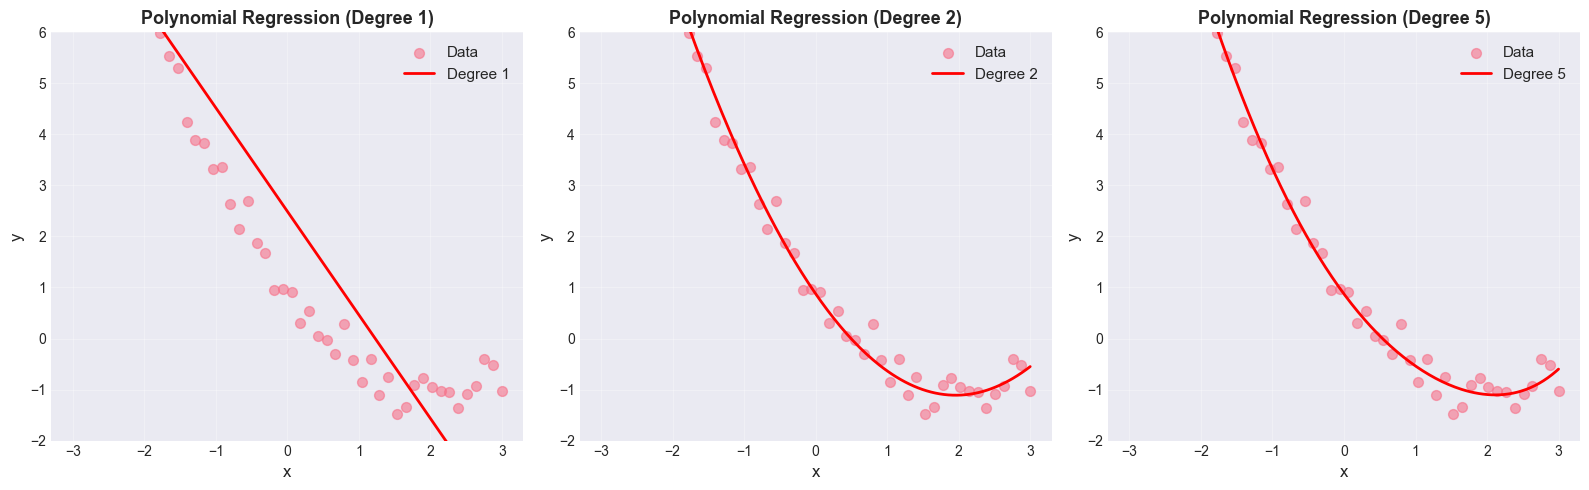

Observations:
• Degree 1: Straight line (underfit)
• Degree 2: Captures the curve (good fit)
• Degree 5: More flexible (risk of overfitting)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

# Generate non-linear data
def generate_data(n_samples=50, noise=0.3):
    X = np.linspace(-3, 3, n_samples)
    y = 0.5 * X**2 - 2*X + 1 + np.random.randn(n_samples) * noise
    return X.reshape(-1, 1), y

X, y = generate_data()

# Fit different polynomial degrees
degrees = [1, 2, 5]
X_plot = np.linspace(-3, 3, 200).reshape(-1, 1)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for ax, degree in zip(axes, degrees):
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X)
    X_plot_poly = poly.transform(X_plot)
    
    # Fit linear regression on polynomial features
    model = LinearRegression()
    model.fit(X_poly, y)
    y_plot = model.predict(X_plot_poly)
    
    # Plot
    ax.scatter(X, y, alpha=0.6, s=50, label='Data')
    ax.plot(X_plot, y_plot, 'r-', linewidth=2, label=f'Degree {degree}')
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('y', fontsize=12)
    ax.set_title(f'Polynomial Regression (Degree {degree})', fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-2, 6)

plt.tight_layout()
plt.show()

print("Observations:")
print("• Degree 1: Straight line (underfit)")
print("• Degree 2: Captures the curve (good fit)")
print("• Degree 5: More flexible (risk of overfitting)")

---
## 2. Creating Polynomial Features

### Feature Transformation

Given input $x$, create features:
$$[1, x, x^2, x^3, ..., x^n]$$

For multiple features $(x_1, x_2)$ with degree 2:
$$[1, x_1, x_2, x_1^2, x_1x_2, x_2^2]$$

### Implementation

In [2]:
# Manual polynomial feature creation
def create_polynomial_features(X, degree):
    """
    Create polynomial features manually
    
    Args:
        X: input features (n_samples, 1)
        degree: polynomial degree
    
    Returns:
        X_poly: polynomial features (n_samples, degree)
    """
    n_samples = X.shape[0]
    X_poly = np.zeros((n_samples, degree))
    
    for i in range(degree):
        X_poly[:, i] = (X[:, 0] ** (i + 1))
    
    return X_poly

# Example
X_example = np.array([[1], [2], [3]])
X_poly_manual = create_polynomial_features(X_example, degree=3)

print("=== MANUAL POLYNOMIAL FEATURES ===")
print("\nOriginal X:")
print(X_example.flatten())
print("\nPolynomial features (degree 3):")
print("  x    x²   x³")
for i in range(len(X_example)):
    print(f"{X_poly_manual[i, 0]:4.0f} {X_poly_manual[i, 1]:4.0f} {X_poly_manual[i, 2]:4.0f}")

# Using sklearn
poly_sklearn = PolynomialFeatures(degree=3, include_bias=False)
X_poly_sklearn = poly_sklearn.fit_transform(X_example)

print("\n=== SKLEARN POLYNOMIAL FEATURES ===")
print("\nFeature names:", poly_sklearn.get_feature_names_out())
print("\nTransformed features:")
print(X_poly_sklearn)

# Multiple features example
X_multi = np.array([[1, 2],
                    [3, 4]])

poly_multi = PolynomialFeatures(degree=2, include_bias=False)
X_poly_multi = poly_multi.fit_transform(X_multi)

print("\n=== MULTIPLE FEATURES (degree 2) ===")
print("\nOriginal shape:", X_multi.shape)
print("Polynomial shape:", X_poly_multi.shape)
print("\nFeature names:", poly_multi.get_feature_names_out(['x1', 'x2']))
print("\nTransformed:")
print("  x1   x2   x1²  x1x2  x2²")
print(X_poly_multi)

=== MANUAL POLYNOMIAL FEATURES ===

Original X:
[1 2 3]

Polynomial features (degree 3):
  x    x²   x³
   1    1    1
   2    4    8
   3    9   27

=== SKLEARN POLYNOMIAL FEATURES ===

Feature names: ['x0' 'x0^2' 'x0^3']

Transformed features:
[[ 1.  1.  1.]
 [ 2.  4.  8.]
 [ 3.  9. 27.]]

=== MULTIPLE FEATURES (degree 2) ===

Original shape: (2, 2)
Polynomial shape: (2, 5)

Feature names: ['x1' 'x2' 'x1^2' 'x1 x2' 'x2^2']

Transformed:
  x1   x2   x1²  x1x2  x2²
[[ 1.  2.  1.  2.  4.]
 [ 3.  4.  9. 12. 16.]]


---
## 3. Implementing Polynomial Regression

### From Scratch

=== TESTING POLYNOMIAL REGRESSION ===

Degree 1:
  R² = 0.8646
  Equation: y = 2.567 + -2.015x

Degree 2:
  R² = 0.9955
  Equation: y = 1.017 + -2.015x + 0.496x^2

Degree 3:
  R² = 0.9955
  Equation: y = 1.017 + -2.024x + 0.496x^2 + 0.002x^3

Degree 4:
  R² = 0.9955
  Equation: y = 1.016 + -2.024x + 0.497x^2 + 0.002x^3 + -0.000x^4


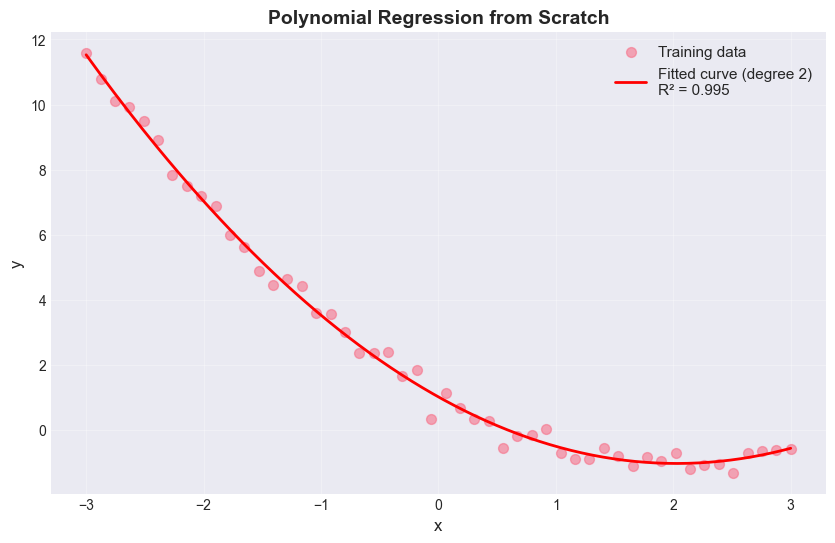

In [3]:
class PolynomialRegression:
    """
    Polynomial Regression from scratch
    """
    
    def __init__(self, degree=2):
        self.degree = degree
        self.weights = None
        self.bias = None
    
    def _create_polynomial_features(self, X):
        """Create polynomial features"""
        n_samples = X.shape[0]
        X_poly = np.zeros((n_samples, self.degree))
        
        for i in range(self.degree):
            X_poly[:, i] = (X[:, 0] ** (i + 1))
        
        return X_poly
    
    def fit(self, X, y):
        """
        Fit polynomial regression using normal equation
        
        Args:
            X: input features (n_samples, 1)
            y: target values (n_samples,)
        """
        # Create polynomial features
        X_poly = self._create_polynomial_features(X)
        
        # Add bias term
        X_with_bias = np.c_[np.ones(X_poly.shape[0]), X_poly]
        
        # Normal equation: w = (X^T X)^(-1) X^T y
        w = np.linalg.lstsq(X_with_bias.T @ X_with_bias,
                           X_with_bias.T @ y,
                           rcond=None)[0]
        
        self.bias = w[0]
        self.weights = w[1:]
        
        return self
    
    def predict(self, X):
        """
        Make predictions
        
        Args:
            X: input features (n_samples, 1)
        
        Returns:
            predictions (n_samples,)
        """
        X_poly = self._create_polynomial_features(X)
        return X_poly @ self.weights + self.bias
    
    def score(self, X, y):
        """Compute R² score"""
        y_pred = self.predict(X)
        ss_res = np.sum((y - y_pred)**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        return 1 - (ss_res / ss_tot)
    
    def get_equation(self):
        """Get the polynomial equation as a string"""
        terms = [f"{self.bias:.3f}"]
        for i, w in enumerate(self.weights, 1):
            if i == 1:
                terms.append(f"{w:.3f}x")
            else:
                terms.append(f"{w:.3f}x^{i}")
        return " + ".join(terms)

# Test the implementation
print("=== TESTING POLYNOMIAL REGRESSION ===")

# Generate data
X_train, y_train = generate_data(n_samples=50, noise=0.3)

# Fit different degrees
for degree in [1, 2, 3, 4]:
    model = PolynomialRegression(degree=degree)
    model.fit(X_train, y_train)
    score = model.score(X_train, y_train)
    
    print(f"\nDegree {degree}:")
    print(f"  R² = {score:.4f}")
    print(f"  Equation: y = {model.get_equation()}")

# Visualize best fit
model_best = PolynomialRegression(degree=2)
model_best.fit(X_train, y_train)

X_plot = np.linspace(-3, 3, 200).reshape(-1, 1)
y_plot = model_best.predict(X_plot)

plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, alpha=0.6, s=50, label='Training data')
plt.plot(X_plot, y_plot, 'r-', linewidth=2, 
         label=f'Fitted curve (degree 2)\nR² = {model_best.score(X_train, y_train):.3f}')
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Polynomial Regression from Scratch', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

---
## 4. The Bias-Variance Tradeoff

### Core Concept

**Total Error = Bias² + Variance + Irreducible Error**

- **Bias**: Error from wrong assumptions (underfitting)
  - High bias → model too simple
  - Example: linear model for non-linear data

- **Variance**: Error from sensitivity to training data (overfitting)
  - High variance → model too complex
  - Example: high-degree polynomial

### The Tradeoff

As model complexity increases:
- Bias ↓ (better fit to training data)
- Variance ↑ (worse generalization)

**Goal**: Find the sweet spot!

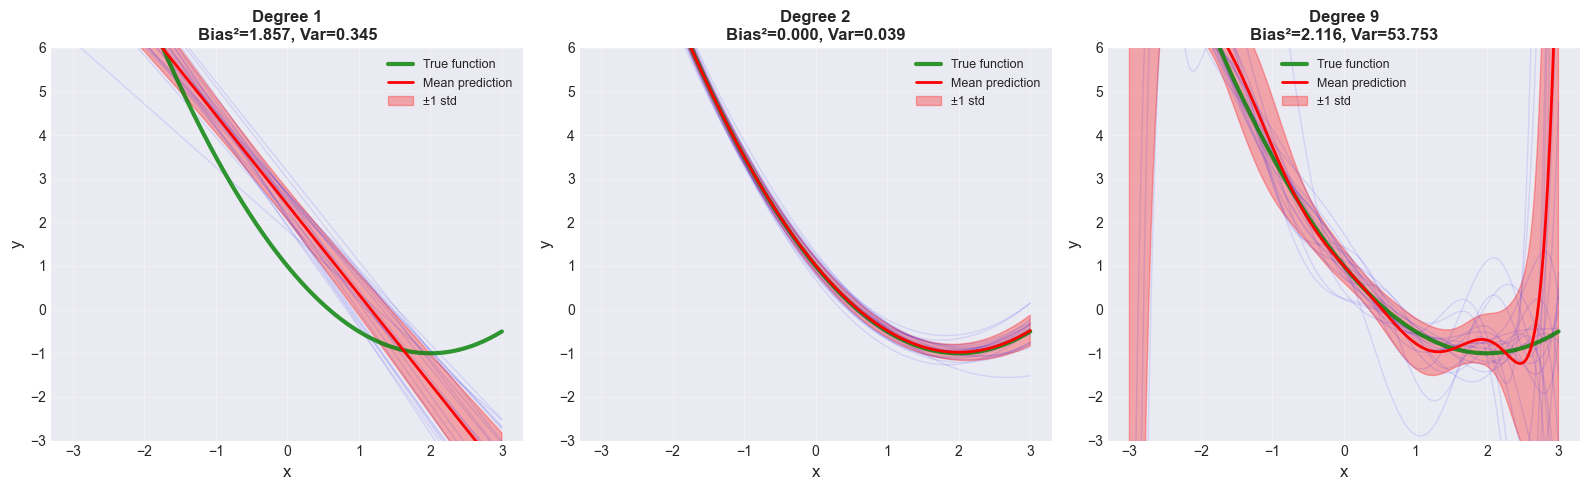

=== BIAS-VARIANCE TRADEOFF ===

Degree 1 (Underfit):
  • High bias (systematic error)
  • Low variance (predictions consistent)
  • Cannot capture true curve

Degree 2 (Just Right):
  • Low bias (close to true function)
  • Low variance (stable predictions)
  • Good balance!

Degree 9 (Overfit):
  • Low bias on training data
  • High variance (predictions vary wildly)
  • Too sensitive to training data


In [4]:
# Demonstrate bias-variance tradeoff
def demonstrate_bias_variance():
    # Generate true function
    np.random.seed(42)
    X_true = np.linspace(-3, 3, 200).reshape(-1, 1)
    y_true = 0.5 * X_true**2 - 2*X_true + 1
    
    # Generate multiple training sets
    n_datasets = 20
    degrees = [1, 2, 9]
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    for ax, degree in zip(axes, degrees):
        all_predictions = []
        
        for i in range(n_datasets):
            # Generate training data with different noise
            X_train = np.random.uniform(-3, 3, 20).reshape(-1, 1)
            y_train = 0.5 * X_train**2 - 2*X_train + 1 + np.random.randn(20, 1) * 0.5
            
            # Fit model
            poly = PolynomialFeatures(degree=degree, include_bias=False)
            X_poly = poly.fit_transform(X_train)
            X_true_poly = poly.transform(X_true)
            
            model = LinearRegression()
            model.fit(X_poly, y_train)
            y_pred = model.predict(X_true_poly)
            
            # Store predictions
            all_predictions.append(y_pred.flatten())
            
            # Plot individual fit
            ax.plot(X_true, y_pred, 'b-', alpha=0.1, linewidth=1)
        
        # Calculate mean prediction and variance
        all_predictions = np.array(all_predictions)
        mean_pred = np.mean(all_predictions, axis=0)
        std_pred = np.std(all_predictions, axis=0)
        
        # Plot
        ax.plot(X_true, y_true, 'g-', linewidth=3, label='True function', alpha=0.8)
        ax.plot(X_true, mean_pred, 'r-', linewidth=2, label='Mean prediction')
        ax.fill_between(X_true.flatten(), 
                        mean_pred - std_pred, 
                        mean_pred + std_pred,
                        alpha=0.3, color='red', label='±1 std')
        
        # Calculate bias and variance
        bias = np.mean((mean_pred - y_true.flatten())**2)
        variance = np.mean(std_pred**2)
        
        ax.set_xlabel('x', fontsize=12)
        ax.set_ylabel('y', fontsize=12)
        ax.set_title(f'Degree {degree}\nBias²={bias:.3f}, Var={variance:.3f}', 
                    fontsize=12, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-3, 6)
    
    plt.tight_layout()
    plt.show()
    
    print("=== BIAS-VARIANCE TRADEOFF ===")
    print("\nDegree 1 (Underfit):")
    print("  • High bias (systematic error)")
    print("  • Low variance (predictions consistent)")
    print("  • Cannot capture true curve")
    
    print("\nDegree 2 (Just Right):")
    print("  • Low bias (close to true function)")
    print("  • Low variance (stable predictions)")
    print("  • Good balance!")
    
    print("\nDegree 9 (Overfit):")
    print("  • Low bias on training data")
    print("  • High variance (predictions vary wildly)")
    print("  • Too sensitive to training data")

demonstrate_bias_variance()

### Visualizing Overfitting

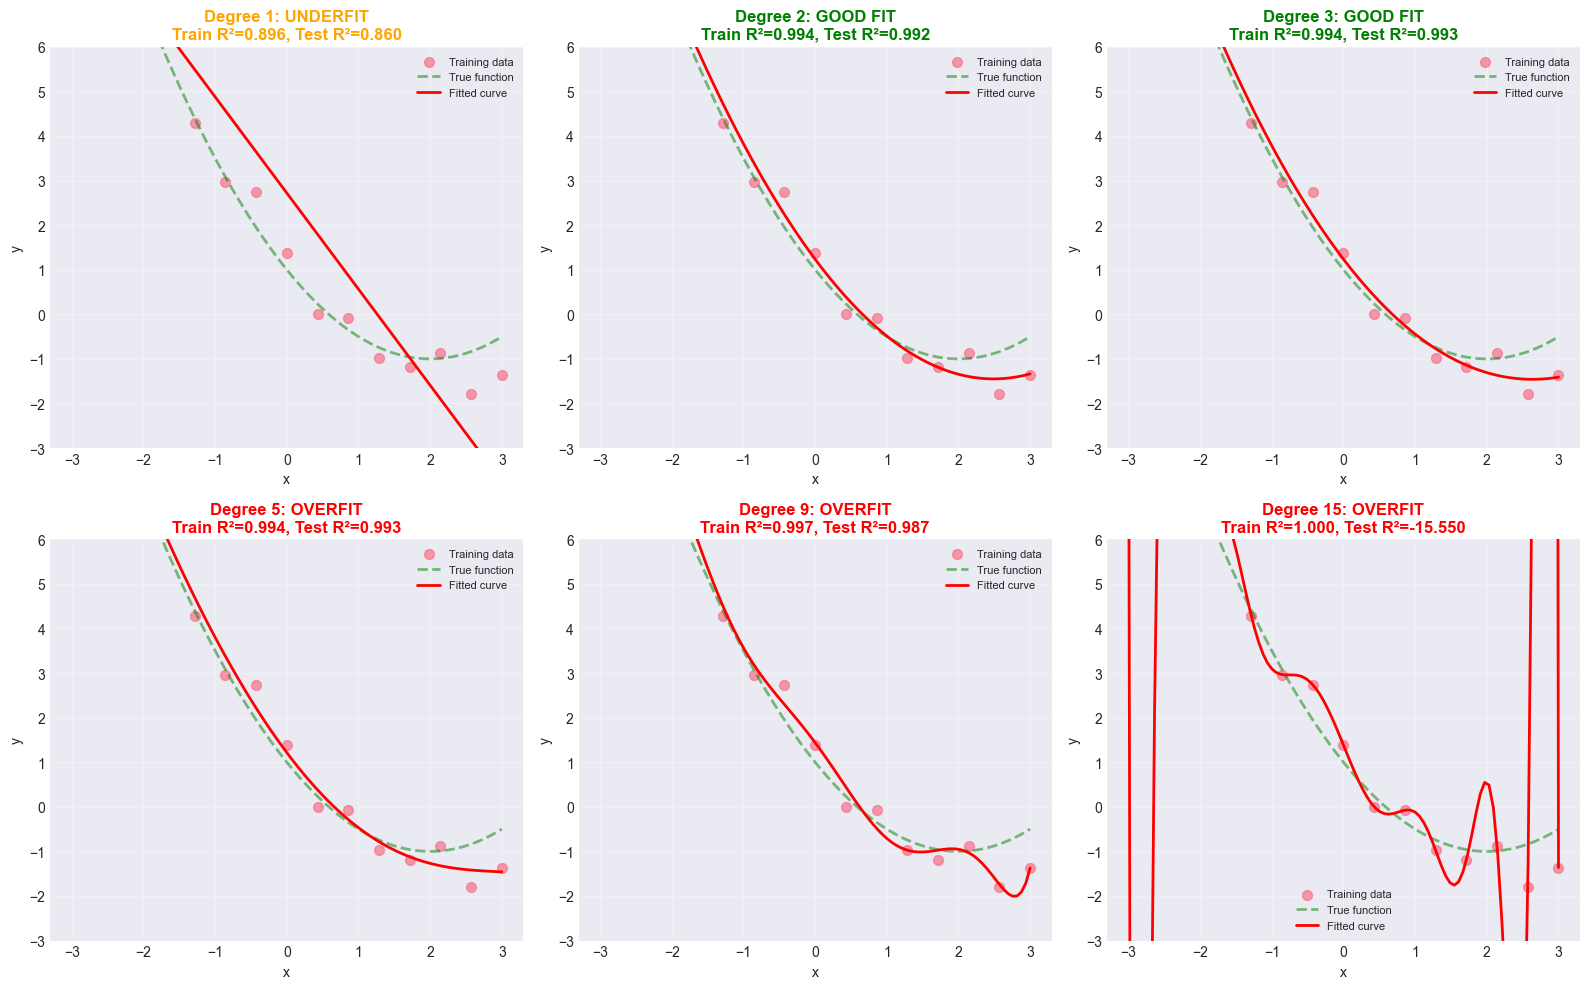

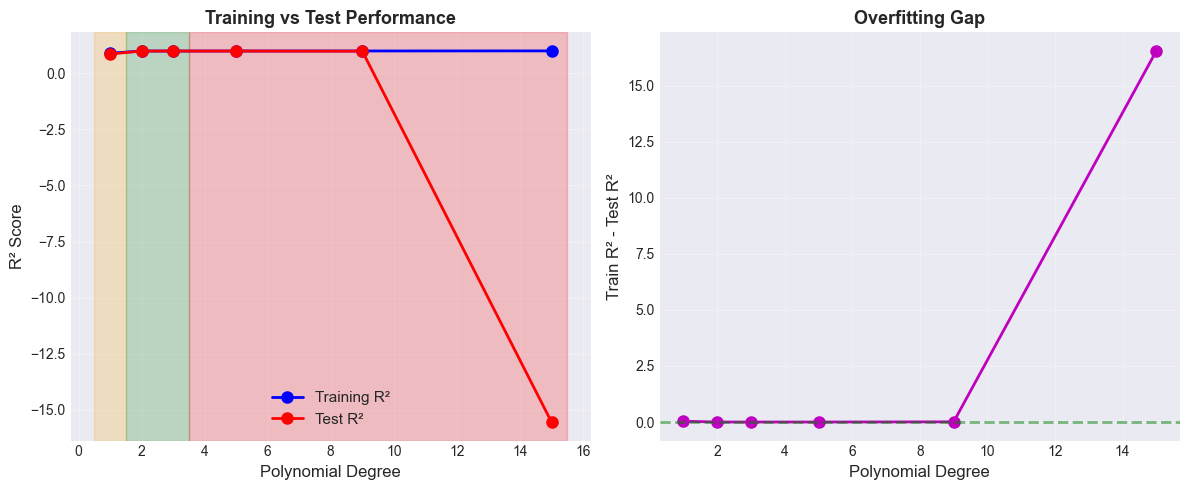


=== KEY OBSERVATIONS ===

1. Training R² always increases with degree
2. Test R² increases then decreases (overfitting)
3. Gap between train and test R² indicates overfitting
4. Optimal degree: 2-3 for this data


In [5]:
# Show progression from underfit to overfit
np.random.seed(42)
X_train = np.linspace(-3, 3, 15).reshape(-1, 1)
y_train = 0.5 * X_train**2 - 2*X_train + 1 + np.random.randn(15, 1) * 0.5

X_test = np.linspace(-3, 3, 100).reshape(-1, 1)
y_test = 0.5 * X_test**2 - 2*X_test + 1

degrees = [1, 2, 3, 5, 9, 15]
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

train_scores = []
test_scores = []

for ax, degree in zip(axes, degrees):
    # Fit model
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)
    
    train_score = r2_score(y_train, y_train_pred)
    test_score = r2_score(y_test, y_test_pred)
    
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    # Plot
    ax.scatter(X_train, y_train, alpha=0.7, s=50, label='Training data')
    ax.plot(X_test, y_test, 'g--', linewidth=2, alpha=0.5, label='True function')
    ax.plot(X_test, y_test_pred, 'r-', linewidth=2, label='Fitted curve')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    # Determine fit quality
    if degree == 1:
        fit_label = 'UNDERFIT'
        color = 'orange'
    elif degree in [2, 3]:
        fit_label = 'GOOD FIT'
        color = 'green'
    else:
        fit_label = 'OVERFIT'
        color = 'red'
    
    ax.set_title(f'Degree {degree}: {fit_label}\nTrain R²={train_score:.3f}, Test R²={test_score:.3f}',
                fontweight='bold', color=color)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-3, 6)

plt.tight_layout()
plt.show()

# Plot learning curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(degrees, train_scores, 'bo-', linewidth=2, markersize=8, label='Training R²')
plt.plot(degrees, test_scores, 'ro-', linewidth=2, markersize=8, label='Test R²')
plt.xlabel('Polynomial Degree', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.title('Training vs Test Performance', fontsize=13, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Mark regions
plt.axvspan(0.5, 1.5, alpha=0.2, color='orange', label='Underfit')
plt.axvspan(1.5, 3.5, alpha=0.2, color='green', label='Good')
plt.axvspan(3.5, 15.5, alpha=0.2, color='red', label='Overfit')

plt.subplot(1, 2, 2)
gap = np.array(train_scores) - np.array(test_scores)
plt.plot(degrees, gap, 'mo-', linewidth=2, markersize=8)
plt.xlabel('Polynomial Degree', fontsize=12)
plt.ylabel('Train R² - Test R²', fontsize=12)
plt.title('Overfitting Gap', fontsize=13, fontweight='bold')
plt.axhline(y=0, color='green', linestyle='--', linewidth=2, alpha=0.5)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== KEY OBSERVATIONS ===")
print("\n1. Training R² always increases with degree")
print("2. Test R² increases then decreases (overfitting)")
print("3. Gap between train and test R² indicates overfitting")
print("4. Optimal degree: 2-3 for this data")

---
## 5. Model Selection with Cross-Validation

### Why Cross-Validation?

**Problem**: Test set performance might be lucky/unlucky

**Solution**: Use k-fold cross-validation

1. Split data into k folds
2. Train on k-1 folds, validate on remaining fold
3. Repeat k times
4. Average the scores

This gives a more robust estimate of model performance!

=== CROSS-VALIDATION RESULTS ===

Degree | Mean R²  | Std R²
------------------------------
     1 | -26.6661 | 47.6685
     2 |  0.4191 |  0.5582
     3 | -0.6691 |  2.6702
     4 | -2.2657 |  5.6575
     5 | -37.2751 | 75.4832
     6 | -232.4601 | 465.4547
     7 | -30.1344 | 39.9779
     8 | -6481.4777 | 12323.7000
     9 | -6196.3345 | 10656.9985
    10 | -19496.3044 | 23906.3607
    11 | -249796.2402 | 399025.7563
    12 | -926054.6847 | 1795192.8182
    13 | -63215837.6380 | 125639395.3127
    14 | -397139023.4511 | 794253064.3638
    15 | -444129742.5462 | 880678667.9840

✓ Best degree: 2 (CV R² = 0.4191)


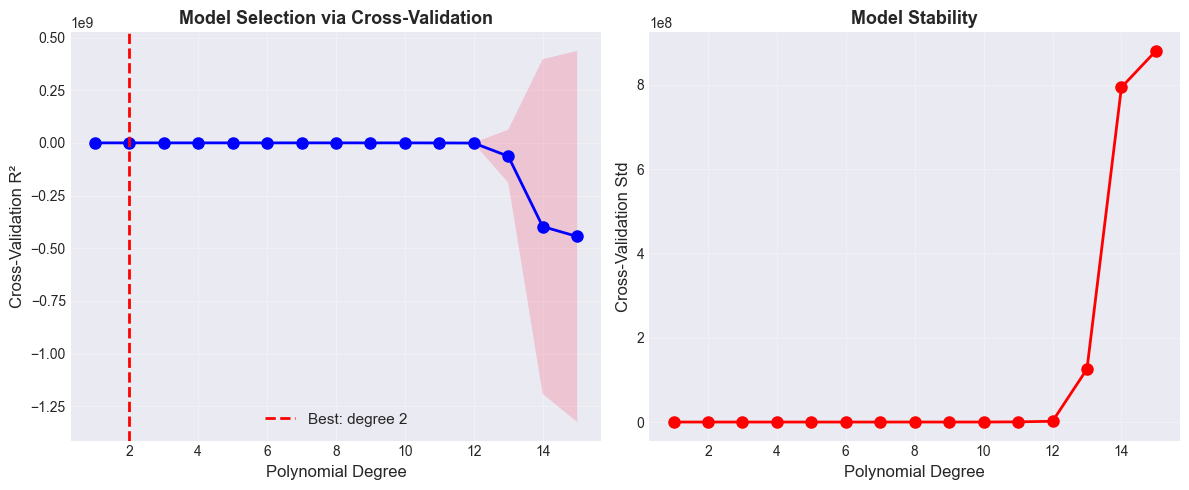


Insights:
• CV score peaks at optimal complexity
• High-degree polynomials have higher variance
• Use CV to avoid overfitting to test set


In [6]:
from sklearn.model_selection import cross_val_score, KFold

# Generate larger dataset
np.random.seed(42)
X_full = np.linspace(-3, 3, 100).reshape(-1, 1)
y_full = 0.5 * X_full**2 - 2*X_full + 1 + np.random.randn(100, 1) * 0.5
y_full = y_full.ravel()

# Try different polynomial degrees
degrees_to_test = range(1, 16)
cv_scores_mean = []
cv_scores_std = []

print("=== CROSS-VALIDATION RESULTS ===")
print("\nDegree | Mean R²  | Std R²")
print("-" * 30)

for degree in degrees_to_test:
    # Create pipeline
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('linear', LinearRegression())
    ])
    
    # Perform 5-fold cross-validation
    scores = cross_val_score(model, X_full, y_full, 
                            cv=5, scoring='r2')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())
    
    print(f"{degree:6d} | {scores.mean():7.4f} | {scores.std():7.4f}")

# Find best degree
best_degree = degrees_to_test[np.argmax(cv_scores_mean)]
best_score = max(cv_scores_mean)

print(f"\n✓ Best degree: {best_degree} (CV R² = {best_score:.4f})")

# Plot cross-validation scores
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(degrees_to_test, cv_scores_mean, 'bo-', linewidth=2, markersize=8)
plt.fill_between(degrees_to_test,
                np.array(cv_scores_mean) - np.array(cv_scores_std),
                np.array(cv_scores_mean) + np.array(cv_scores_std),
                alpha=0.3)
plt.axvline(x=best_degree, color='red', linestyle='--', linewidth=2,
           label=f'Best: degree {best_degree}')
plt.xlabel('Polynomial Degree', fontsize=12)
plt.ylabel('Cross-Validation R²', fontsize=12)
plt.title('Model Selection via Cross-Validation', fontsize=13, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(degrees_to_test, cv_scores_std, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Polynomial Degree', fontsize=12)
plt.ylabel('Cross-Validation Std', fontsize=12)
plt.title('Model Stability', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInsights:")
print("• CV score peaks at optimal complexity")
print("• High-degree polynomials have higher variance")
print("• Use CV to avoid overfitting to test set")

---
## 6. Regularization for Polynomial Models

### The Problem

High-degree polynomials can have very large coefficients, leading to:
- Overfitting
- Numerical instability
- Wild predictions outside training range

### The Solution: Regularization

**Ridge (L2)**: Penalize large coefficients
$$L = MSE + \alpha \sum w_i^2$$

**Lasso (L1)**: Force some coefficients to zero
$$L = MSE + \alpha \sum |w_i|$$

/Users/savithavijayarangan/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.603e+00, tolerance: 3.346e-02
  model = cd_fast.enet_coordinate_descent(


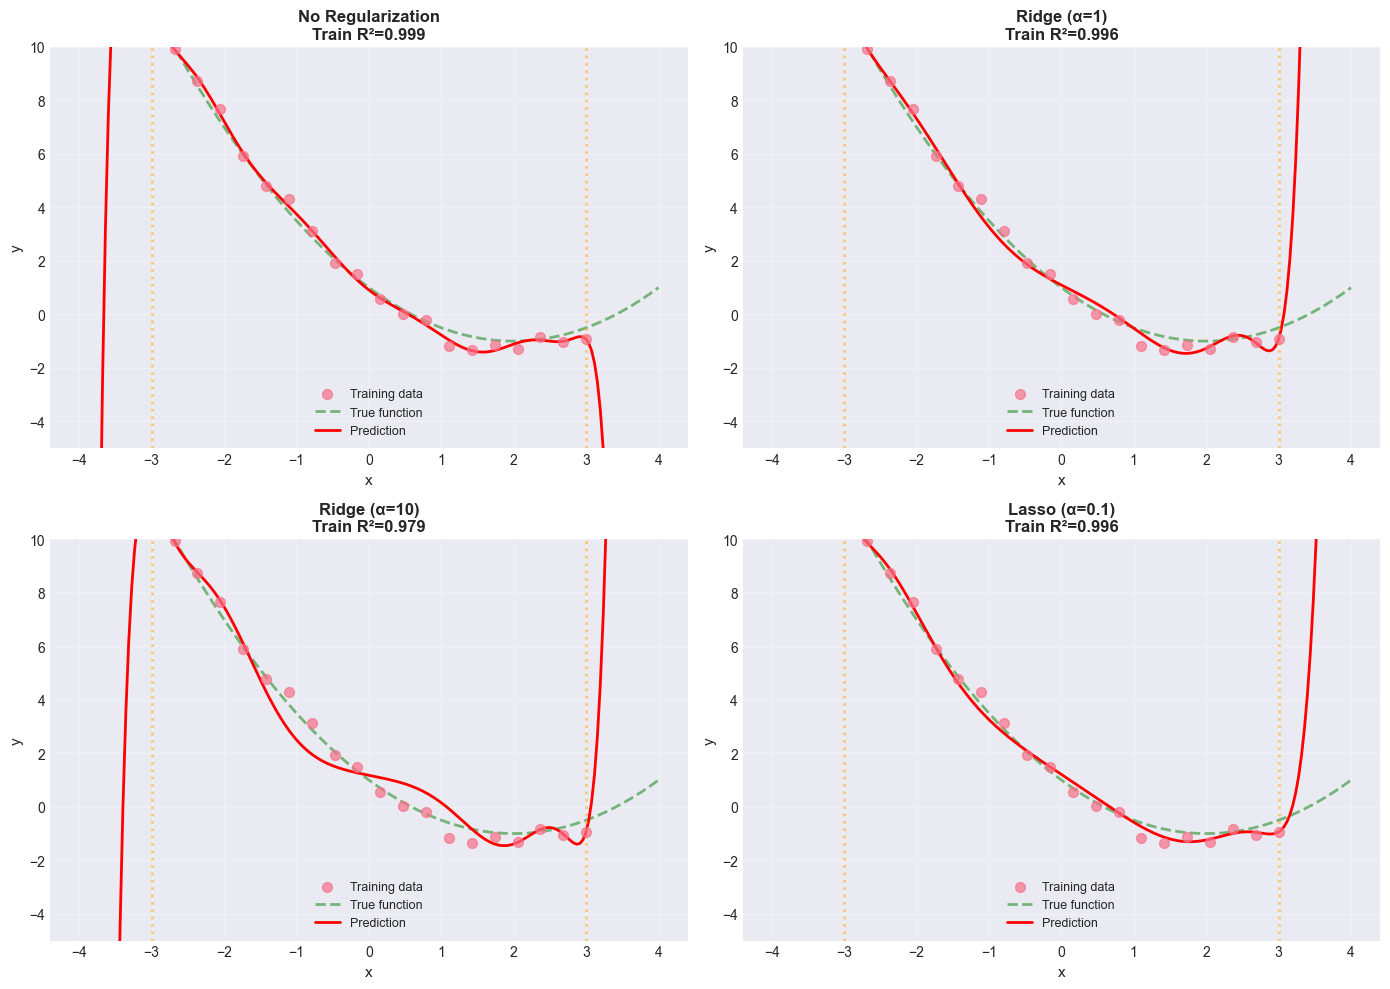

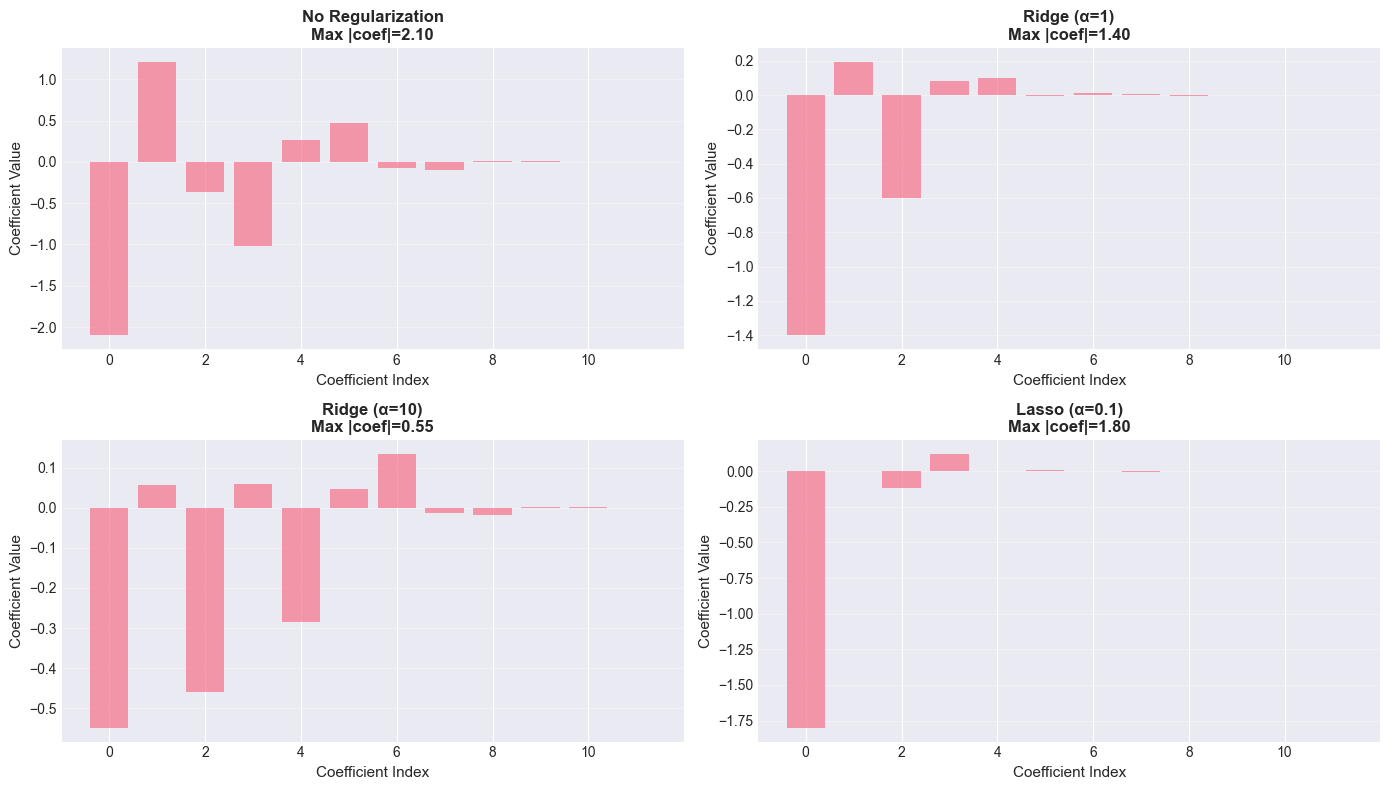

=== REGULARIZATION EFFECTS ===

No Regularization:
  • Wild oscillations outside training range
  • Very large coefficients
  • Overfitting

Ridge Regularization:
  • Smoother predictions
  • Smaller coefficients
  • Better extrapolation

Lasso Regularization:
  • Some coefficients exactly zero
  • Automatic feature selection
  • Simpler model


In [7]:
from sklearn.linear_model import Lasso

# Compare regularized vs unregularized high-degree polynomial
np.random.seed(42)
X_train = np.linspace(-3, 3, 20).reshape(-1, 1)
y_train = 0.5 * X_train**2 - 2*X_train + 1 + np.random.randn(20, 1) * 0.3
y_train = y_train.ravel()

X_test = np.linspace(-4, 4, 200).reshape(-1, 1)
y_test_true = 0.5 * X_test**2 - 2*X_test + 1

degree = 12

# Models
models = {
    'No Regularization': Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('linear', LinearRegression())
    ]),
    'Ridge (α=1)': Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('ridge', Ridge(alpha=1.0))
    ]),
    'Ridge (α=10)': Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('ridge', Ridge(alpha=10.0))
    ]),
    'Lasso (α=0.1)': Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('lasso', Lasso(alpha=0.1, max_iter=10000))
    ])
}

# Train and compare
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, (name, model) in zip(axes, models.items()):
    # Fit
    model.fit(X_train, y_train)
    
    # Predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Scores
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Plot
    ax.scatter(X_train, y_train, alpha=0.7, s=50, label='Training data', zorder=3)
    ax.plot(X_test, y_test_true, 'g--', linewidth=2, alpha=0.5, label='True function')
    ax.plot(X_test, y_test_pred, 'r-', linewidth=2, label='Prediction')
    ax.set_xlabel('x', fontsize=11)
    ax.set_ylabel('y', fontsize=11)
    ax.set_title(f'{name}\nTrain R²={train_r2:.3f}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-5, 10)
    ax.axvline(x=-3, color='orange', linestyle=':', linewidth=2, alpha=0.5)
    ax.axvline(x=3, color='orange', linestyle=':', linewidth=2, alpha=0.5)

plt.tight_layout()
plt.show()

# Compare coefficients
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for ax, (name, model) in zip(axes, models.items()):
    # Get coefficients (skip bias term)
    if 'lasso' in model.named_steps:
        coef = model.named_steps['lasso'].coef_[1:]  # Skip intercept
    elif 'ridge' in model.named_steps:
        coef = model.named_steps['ridge'].coef_[1:]
    else:
        coef = model.named_steps['linear'].coef_[1:]
    
    # Plot
    ax.bar(range(len(coef)), coef, alpha=0.7)
    ax.set_xlabel('Coefficient Index', fontsize=11)
    ax.set_ylabel('Coefficient Value', fontsize=11)
    ax.set_title(f'{name}\nMax |coef|={np.max(np.abs(coef)):.2f}', 
                fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("=== REGULARIZATION EFFECTS ===")
print("\nNo Regularization:")
print("  • Wild oscillations outside training range")
print("  • Very large coefficients")
print("  • Overfitting")

print("\nRidge Regularization:")
print("  • Smoother predictions")
print("  • Smaller coefficients")
print("  • Better extrapolation")

print("\nLasso Regularization:")
print("  • Some coefficients exactly zero")
print("  • Automatic feature selection")
print("  • Simpler model")

---
## 7. Real-World Application

### Temperature Prediction Example

=== TEMPERATURE PREDICTION ===
Training samples: 146
Test samples: 37


/Users/savithavijayarangan/miniconda3/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.50108e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/savithavijayarangan/miniconda3/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.44767e-27): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/savithavijayarangan/miniconda3/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.10818e-47): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


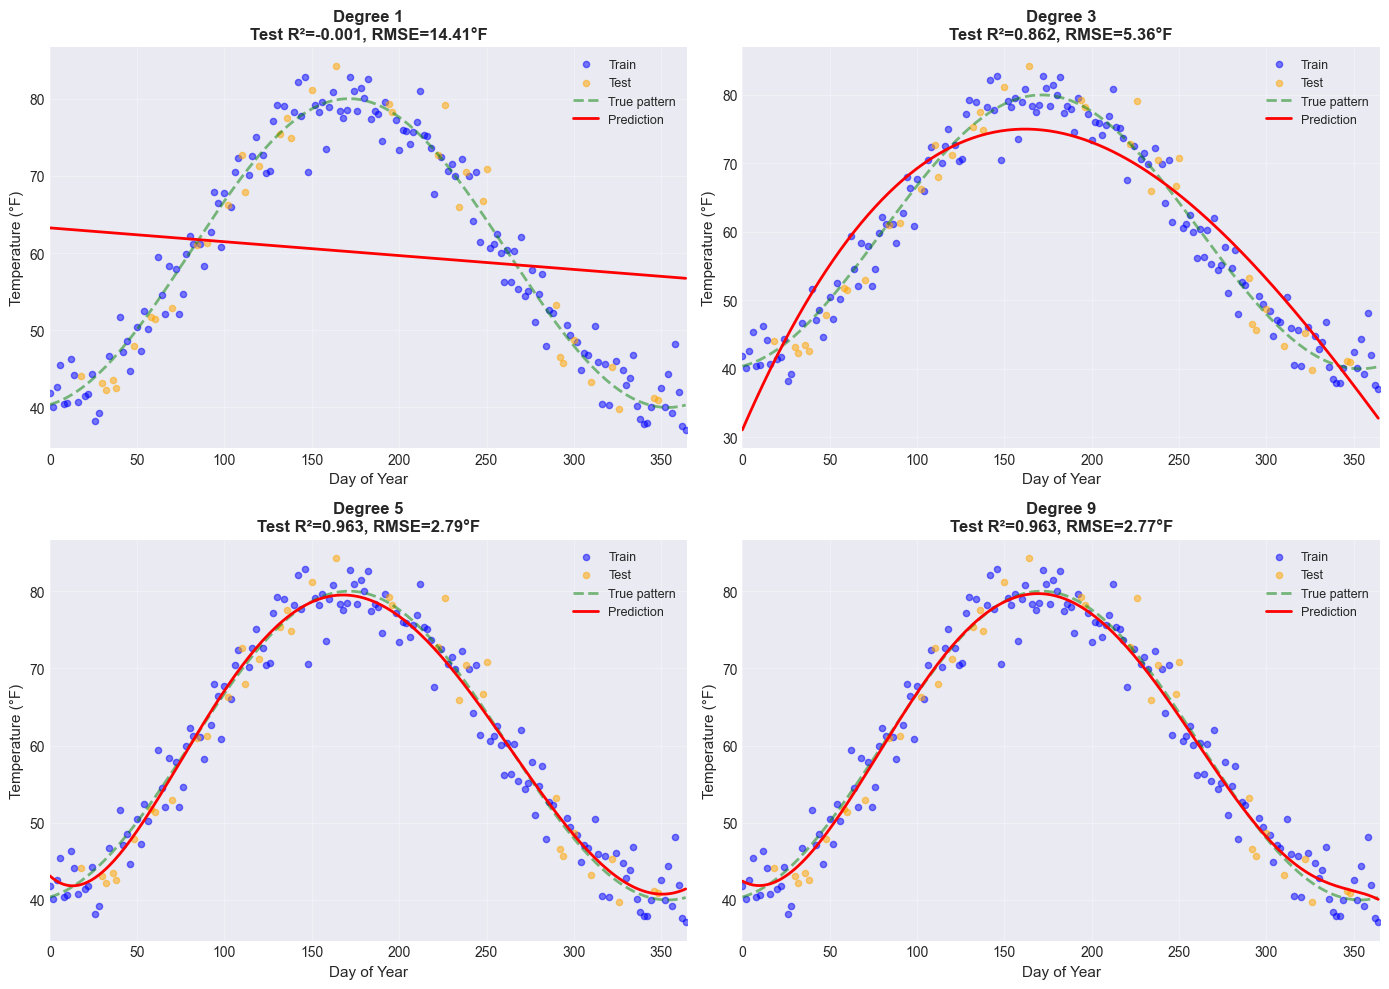


=== MODEL COMPARISON ===
 Degree  Train R²   Test R²  Test RMSE
      1  0.017560 -0.001321  14.407565
      3  0.878510  0.861570   5.356966
      5  0.961750  0.962583   2.785084
      9  0.962254  0.962993   2.769769

✓ Best model: Degree 9 (Test R² = 0.9630)

Insights:
• Higher degrees capture seasonal pattern better
• Regularization prevents overfitting
• Degree 5-9 works well for this cyclic data


In [8]:
# Simulate temperature data (seasonal pattern)
np.random.seed(42)

# Day of year (0-365)
days = np.arange(0, 365, 2)

# True temperature (sinusoidal pattern)
temp_true = 60 + 20 * np.sin(2 * np.pi * (days - 80) / 365)

# Observed temperature (with noise)
temp_observed = temp_true + np.random.randn(len(days)) * 3

# Split data
X_days = days.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(
    X_days, temp_observed, test_size=0.2, random_state=42
)

print("=== TEMPERATURE PREDICTION ===")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# Try different models
degrees = [1, 3, 5, 9]
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Sort for plotting
X_all_sorted = np.sort(X_days, axis=0)
temp_true_sorted = 60 + 20 * np.sin(2 * np.pi * (X_all_sorted - 80) / 365)

results = []

for ax, degree in zip(axes, degrees):
    # Create and train model
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('ridge', Ridge(alpha=1.0))
    ])
    
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_all_pred = model.predict(X_all_sorted)
    
    # Metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    results.append({
        'Degree': degree,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Test RMSE': test_rmse
    })
    
    # Plot
    ax.scatter(X_train, y_train, alpha=0.5, s=20, label='Train', color='blue')
    ax.scatter(X_test, y_test, alpha=0.5, s=20, label='Test', color='orange')
    ax.plot(X_all_sorted, temp_true_sorted, 'g--', linewidth=2, 
           alpha=0.5, label='True pattern')
    ax.plot(X_all_sorted, y_all_pred, 'r-', linewidth=2, label='Prediction')
    ax.set_xlabel('Day of Year', fontsize=11)
    ax.set_ylabel('Temperature (°F)', fontsize=11)
    ax.set_title(f'Degree {degree}\nTest R²={test_r2:.3f}, RMSE={test_rmse:.2f}°F',
                fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 365)

plt.tight_layout()
plt.show()

# Display results
import pandas as pd
results_df = pd.DataFrame(results)
print("\n=== MODEL COMPARISON ===")
print(results_df.to_string(index=False))

best_model_idx = results_df['Test R²'].idxmax()
best_degree = results_df.loc[best_model_idx, 'Degree']
best_r2 = results_df.loc[best_model_idx, 'Test R²']

print(f"\n✓ Best model: Degree {best_degree} (Test R² = {best_r2:.4f})")
print("\nInsights:")
print("• Higher degrees capture seasonal pattern better")
print("• Regularization prevents overfitting")
print("• Degree 5-9 works well for this cyclic data")

---
## 8. Best Practices

### Checklist for Polynomial Regression

In [9]:
print("=== POLYNOMIAL REGRESSION BEST PRACTICES ===")

print("\n1. ALWAYS SCALE FEATURES")
print("   • Polynomial features can have vastly different scales")
print("   • Use StandardScaler or MinMaxScaler")
print("   • Especially important for high degrees")

print("\n2. USE REGULARIZATION")
print("   • Ridge for general use")
print("   • Lasso for feature selection")
print("   • Always tune regularization parameter")

print("\n3. SELECT DEGREE CAREFULLY")
print("   • Use cross-validation")
print("   • Start low (2-3), increase if needed")
print("   • Watch for overfitting (train vs test gap)")

print("\n4. VALIDATE PROPERLY")
print("   • Use train/validation/test split")
print("   • K-fold cross-validation for model selection")
print("   • Never tune on test set!")

print("\n5. CHECK EXTRAPOLATION")
print("   • Polynomials behave wildly outside training range")
print("   • Be cautious with predictions beyond training data")
print("   • Regularization helps but doesn't eliminate this")

print("\n6. VISUALIZE")
print("   • Plot fitted curves")
print("   • Check residuals")
print("   • Look at coefficient magnitudes")

print("\n7. CONSIDER ALTERNATIVES")
print("   • Splines for more flexibility")
print("   • GAMs (Generalized Additive Models)")
print("   • Neural networks for complex patterns")

# Demonstrate feature scaling importance
print("\n\n=== EXAMPLE: IMPORTANCE OF FEATURE SCALING ===")

X_example = np.array([[1], [2], [3], [4], [5]])
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X_example)

print("\nWithout scaling:")
print("  x    x²    x³")
for row in X_poly:
    print(f"{row[0]:4.0f} {row[1]:5.0f} {row[2]:6.0f}")
print("\nNote: x³ is 125× larger than x!")

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_example)
X_poly_scaled = poly.fit_transform(X_scaled)

print("\nWith scaling:")
print("   x     x²    x³")
for row in X_poly_scaled:
    print(f"{row[0]:5.2f} {row[1]:5.2f} {row[2]:5.2f}")
print("\n✓ All features have similar scales!")

=== POLYNOMIAL REGRESSION BEST PRACTICES ===

1. ALWAYS SCALE FEATURES
   • Polynomial features can have vastly different scales
   • Use StandardScaler or MinMaxScaler
   • Especially important for high degrees

2. USE REGULARIZATION
   • Ridge for general use
   • Lasso for feature selection
   • Always tune regularization parameter

3. SELECT DEGREE CAREFULLY
   • Use cross-validation
   • Start low (2-3), increase if needed
   • Watch for overfitting (train vs test gap)

4. VALIDATE PROPERLY
   • Use train/validation/test split
   • K-fold cross-validation for model selection
   • Never tune on test set!

5. CHECK EXTRAPOLATION
   • Polynomials behave wildly outside training range
   • Be cautious with predictions beyond training data
   • Regularization helps but doesn't eliminate this

6. VISUALIZE
   • Plot fitted curves
   • Check residuals
   • Look at coefficient magnitudes

7. CONSIDER ALTERNATIVES
   • Splines for more flexibility
   • GAMs (Generalized Additive Models)
   

---
## 9. Practice Exercises

### Exercise 1: Find Optimal Degree
Use cross-validation to find the optimal polynomial degree for given data

In [10]:
# Exercise 1 - Your code here
# Generate data with cubic relationship
# Use CV to find best degree between 1-10


### Exercise 2: Regularization Tuning
For a degree-10 polynomial, find the optimal Ridge alpha parameter

In [11]:
# Exercise 2 - Your code here


### Exercise 3: Extrapolation Analysis
Compare how different degrees extrapolate beyond training range

In [12]:
# Exercise 3 - Your code here


---
## 10. Key Takeaways

### Core Concepts:
1. ✅ **Polynomial regression** = linear regression on polynomial features
2. ✅ **More flexible** than linear but **risk of overfitting**
3. ✅ **Bias-variance tradeoff**: Balance model complexity
4. ✅ **Cross-validation**: Essential for model selection
5. ✅ **Regularization**: Prevents overfitting in high-degree polynomials

### When to Use:
- ✅ Data shows clear non-linear pattern
- ✅ Relationship can be approximated by polynomial
- ✅ Need interpretable non-linear model
- ❌ Very complex relationships (consider other methods)
- ❌ Need to extrapolate far beyond training data

### Key Formula:
$$y = w_0 + w_1x + w_2x^2 + ... + w_nx^n$$

### Model Selection Process:
1. Split data (train/validation/test)
2. Try different degrees (typically 1-5)
3. Use cross-validation
4. Apply regularization if needed
5. Evaluate on test set once

### Common Pitfalls:
- ❌ Using too high degree (overfitting)
- ❌ Not scaling features
- ❌ Not using regularization
- ❌ Extrapolating beyond training range
- ❌ Tuning on test set

---

**Congratulations! You understand polynomial regression! 🎉**

**You can now model non-linear relationships while avoiding overfitting!**